# **Estimating the drift capacity of RC columns using Machine Learning**

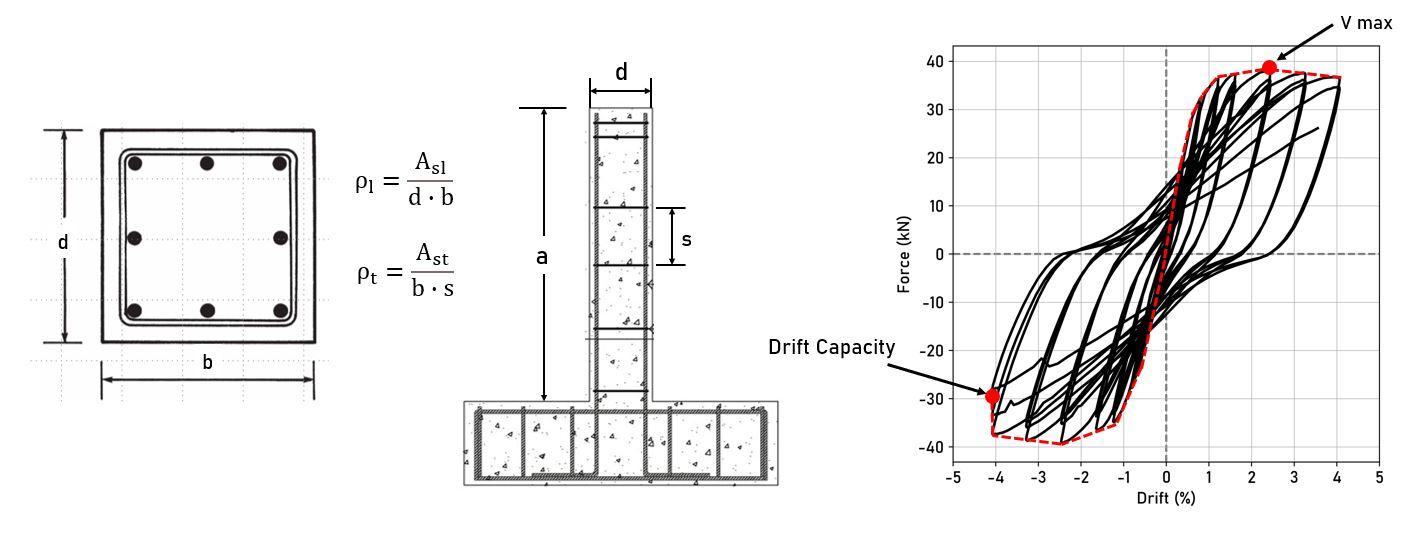

In [2]:
# @title Click the Play button to run the code. { vertical-output: true, form-width: "50%", display-mode: "form" }
# Import necessary libraries
import lightgbm as lgb
import numpy as np
import pandas as pd
import os
from pickle import dump, load
from ipywidgets import *
from IPython.display import display, HTML, Javascript
from google.colab import drive
import gdown

# Function to pre-train the model
def pretrain_model():
    file_id = '13okqZ_om9rmtT6eJZPnd128XbUWKWVOB'
    file_path = f'/content/RC_column_database.csv'  # Local path where the file will be saved
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, file_path, quiet=True)

    # Load data
    columns_to_load = [3, 4, 9, 11, 12, 14, 15, 16, 17, 18, 21]
    data = pd.read_csv(file_path, skiprows=1, delimiter=",", usecols=columns_to_load)

    # Extract features and labels
    X = data.iloc[:, :-1].values  # Column properties
    Y = data.iloc[:, -1].values   # Measured drift capacity

    X[:, 0] = X[:, 0] * 25.4  # a, aspect ratio
    X[:, 2] = X[:, 2] / 145   # fyt, yield strength of transverse reinforcement
    X[:, 4] = X[:, 4] / 145   # fc, compressive strength of concrete
    X[:, 8] = X[:, 8] / 145 * 100  # ρl*fyl
    X[:, 9] = X[:, 9] / 145 * 100  # ρt*fyt

      # Create a LightGBM dataset for training
    train_data = lgb.Dataset(X, label=Y)

    # Define hyperparameters for the LightGBM model
    params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'max_bin': 100,
        'num_leaves': 10,
        'max_depth': 10,
        'learning_rate': 0.05,
        'feature_fraction': 0.3,
    }

    # Turn off warning messages (set logging level to 'silent')
    params['verbose'] = -1

    # Train the LightGBM model
    num_round = 1200
    bst = lgb.train(params, train_data, num_round)
    return bst

# Function to load the pre-trained model
def load_pretrained_model():
    fl = 'pretrained_model.pkl'

    if os.path.isfile(fl):
        with open(fl, 'rb') as fp:
            bst = load(fp)
    else:
        bst = pretrain_model()
        with open(fl, 'wb') as fp:
            dump(bst, fp)
    return bst

# Function to calculate the drift capacity
def _drift_calculator(a, d, s, fc, fyl, fyt, rhol, rhot, v, lbd, bst):
    input_data = np.transpose(np.array([[a], [a/d], [fyt], [s/d], [fc], [v], [s/lbd], [a/s], [rhol*fyl], [rhot*fyt]], dtype=float))
    y_pred = bst.predict(input_data)

    # Output the estimated drift capacity in bold, larger font, and a different font style
    display(HTML(f"<p style='font-size:24px; font-weight:bold; font-family:Bahnschrift;'>Estimated Drift Capacity: {y_pred[0]:.2f} %</p>"))

# Custom CSS to style the sliders
custom_css = """
<style>
    .widget-label {
        font-family: Bahnschrift;
        font-size: 18px;
    }
    .widget-hbox .widget-label {
        min-width: 300px;
    }
    .widget-slider .slider, .widget-slider .slider-value {
        font-family: Bahnschrift;
        font-size: 18px;
    }
    .widget-slider .slider-readout {
        font-family: Bahnschrift;
        font-size: 18px;
    }
    .widget-readout {
        font-family: Bahnschrift;
        font-size: 18px;
    }
</style>
"""

# Function to create interactive widgets
def drift_calculator():
    bst = load_pretrained_model()

    # Create sliders with descriptions and layout adjustments
    sliders = [
        ("a (mm) - Shear span", 1000, 200, 2000, 50, "0.0f"),
        ("d (mm) - Column section depth", 500, 100, 1000, 10, "0.0f"),
        ("s (mm) - Spacing of transverse reinforcement", 100, 50, 500, 10, "0.0f"),
        ("f'c (MPa) - Compressive strength of concrete", 30, 20, 90, 1, "0.0f"),
        ("fyl (MPa) - Longitudinal reinforcement yield strength", 500, 250, 550, 10, "0.0f"),
        ("fyt (MPa) - Transverse reinforcement yield strength", 500, 250, 1000, 10, "0.0f"),
        ("ρl (%) - Longitudinal reinforcement ratio", 2.0, 0.0, 5.0, 0.1, "0.1f"),
        ("ρt (%) - Transverse area reinforcement ratio", 0.4, 0.0, 2.0, 0.05, "0.2f"),
        ("v - Axial load ratio (N / f'c * Ag)", 0.2, 0.0, 0.75, 0.05, "0.2f"),
        ("lbd (mm) - Longitudinal bar diameter", 25, 5, 40, 1, "0.0f"),
    ]

    slider_widgets = []
    for desc, val, min_val, max_val, step, fmt in sliders:
        slider = FloatSlider(value=val, min=min_val, max=max_val, step=step, continuous_update=True, layout=Layout(width='400px'), style={'description_width': 'initial'}, readout_format=fmt)
        label = Label(desc, layout=Layout(width='300px'))
        slider_widgets.append(HBox([label, slider]))

    # Interactive output widget
    io = interactive_output(_drift_calculator, {
        'a': slider_widgets[0].children[1], 'd': slider_widgets[1].children[1], 's': slider_widgets[2].children[1],
        'fc': slider_widgets[3].children[1], 'fyl': slider_widgets[4].children[1], 'fyt': slider_widgets[5].children[1],
        'rhol': slider_widgets[6].children[1], 'rhot': slider_widgets[7].children[1], 'v': slider_widgets[8].children[1],
        'lbd': slider_widgets[9].children[1], 'bst': fixed(bst)
    })

    # Inject custom CSS
    display(HTML(custom_css))

    # Display widgets
    display(VBox(slider_widgets + [io]))

# Run the interactive drift calculator
drift_calculator()

This repository uses existing data of RC columns subjected to cyclic loading to train a Gradient-Boosted Decision Tree (GBDT) machine learning algorithm to estimate drift capacity. Drift capacity is defined as the drift measured at a 20% loss in lateral resistance. A total of 341 RC column tests from the ACI-369 database are used to train the ML algorithm.

**Please get in touch if you would like to share more tests not currently included in the repository.**

Here is a link to the existing databse of columns :
https://drive.google.com/file/d/13okqZ_om9rmtT6eJZPnd128XbUWKWVOB/view?usp=drive_link


### **Results from K-fold cross validation of the database of RC Columns is shown below**

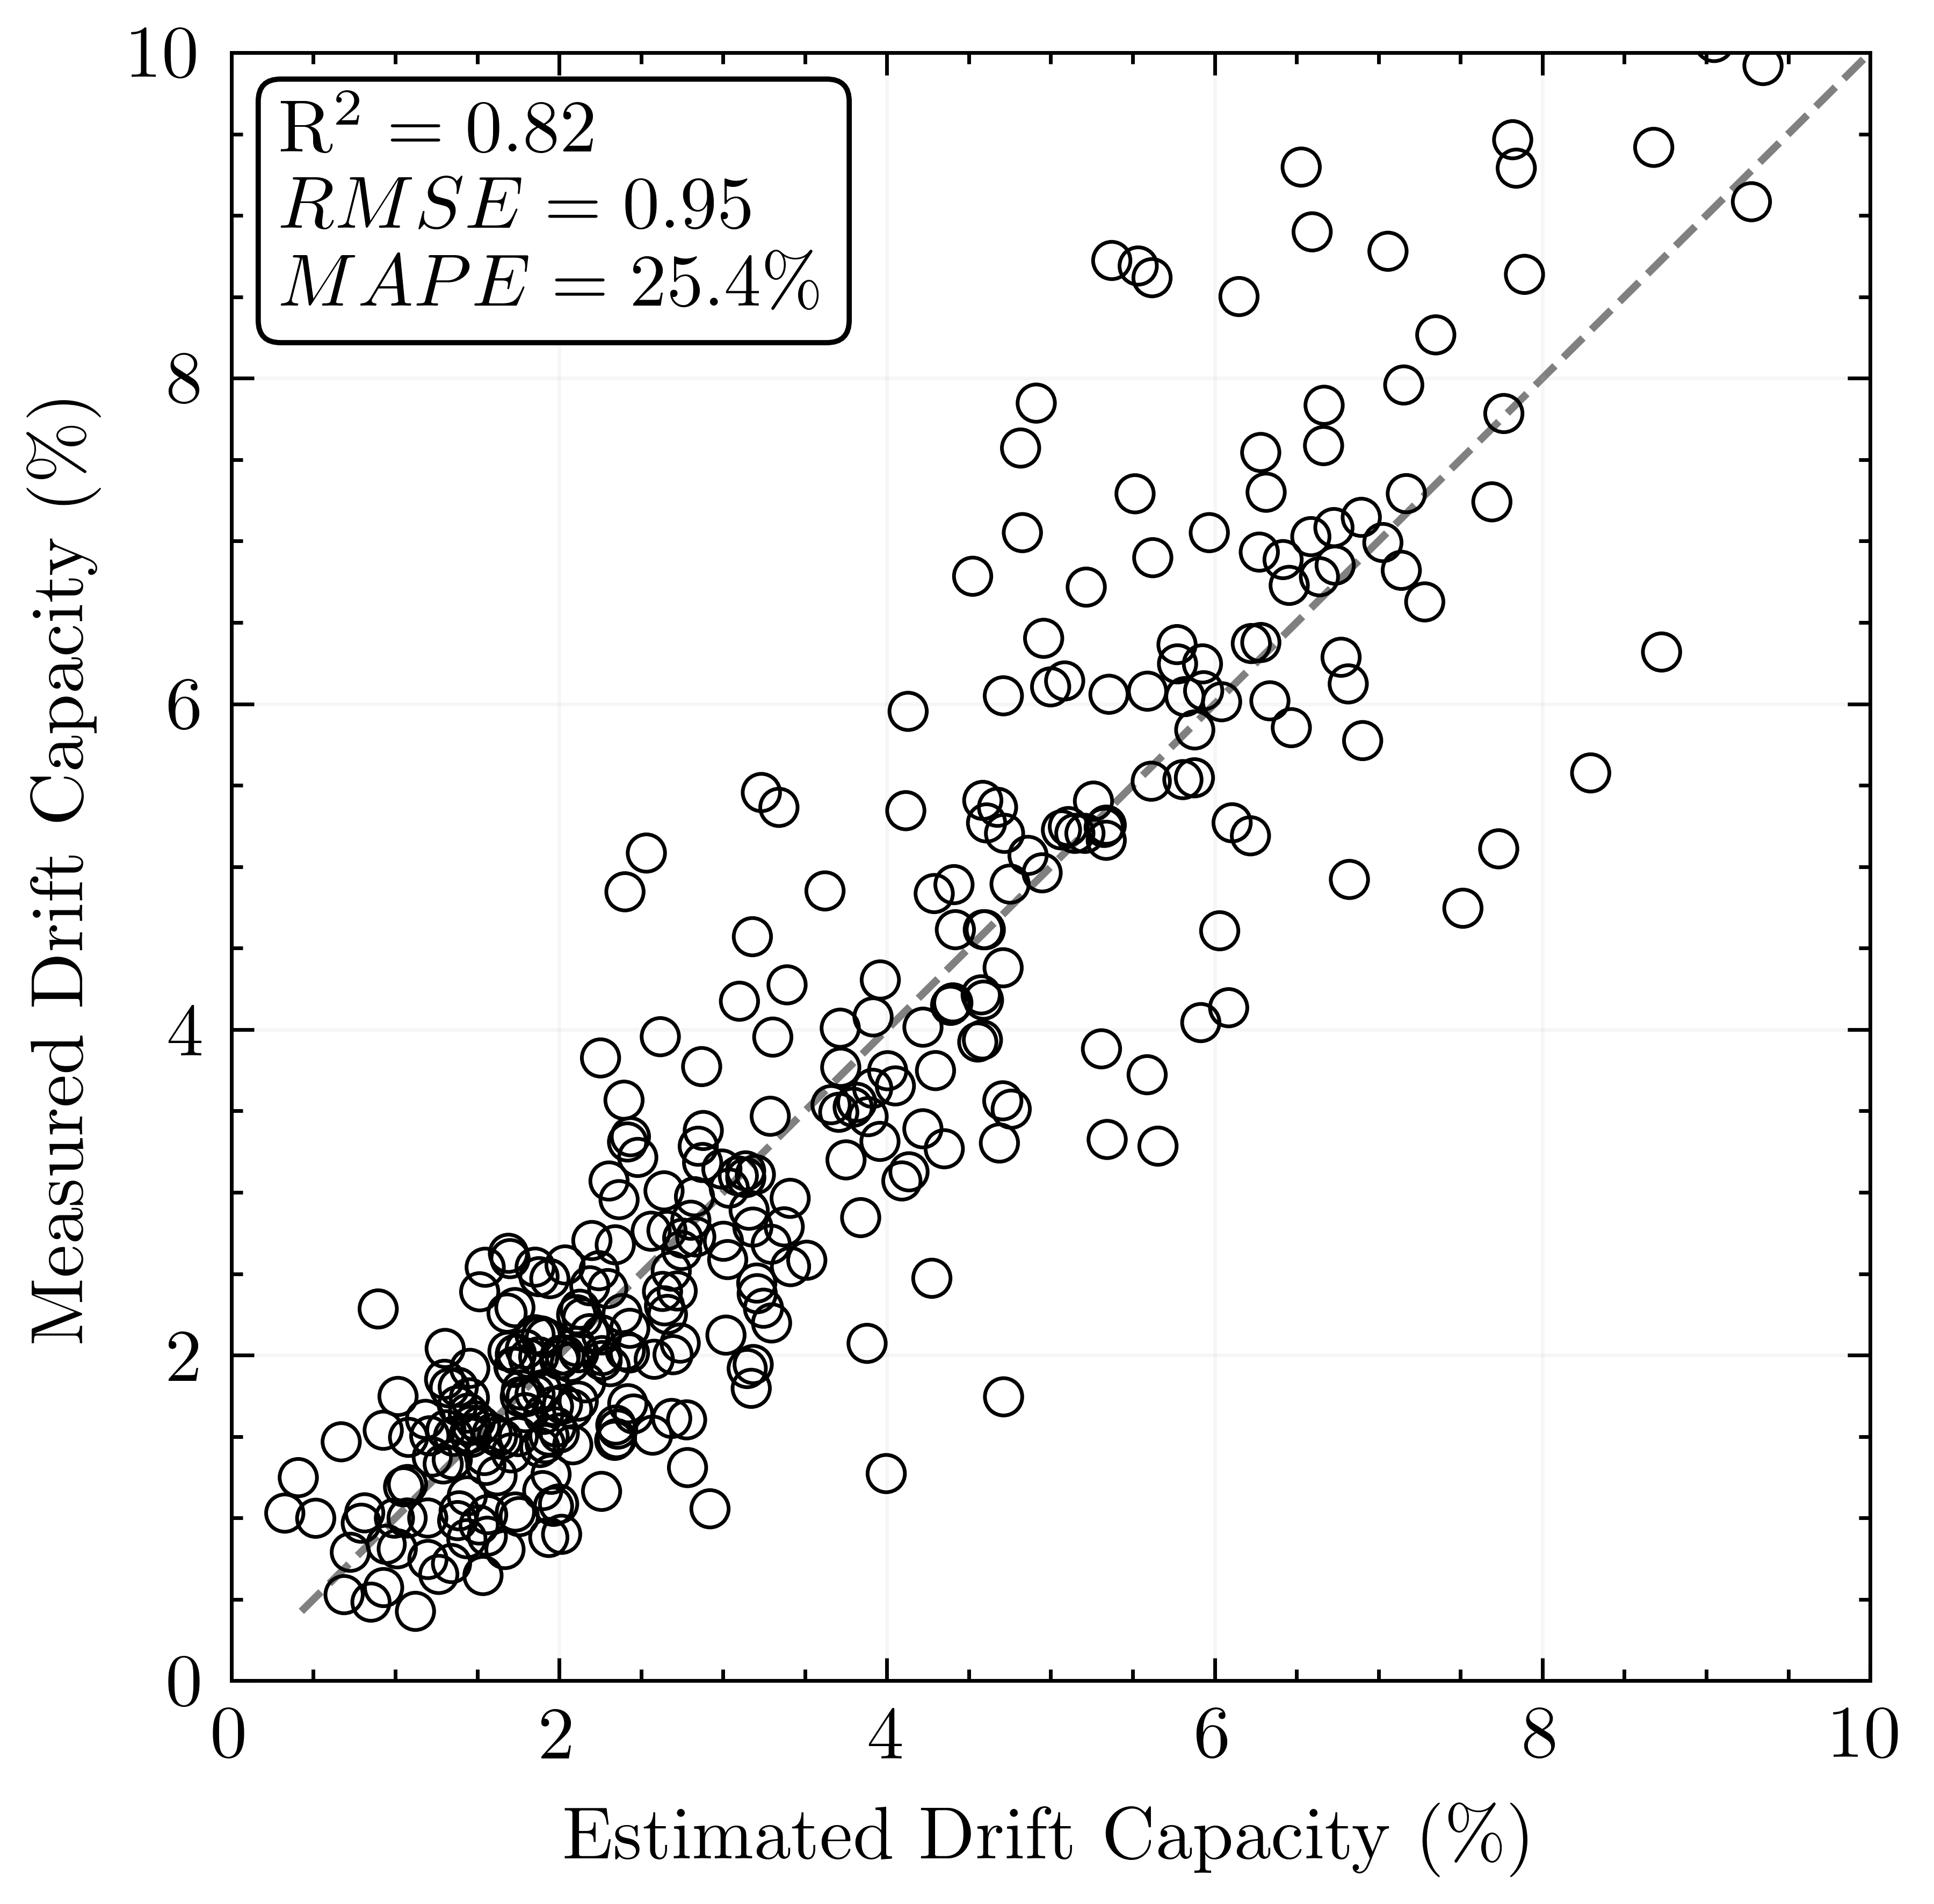